Цели работы:
1. Загрузка тренировочного датасета
2. Подключение к облачной базе данных MangoDB Atlas
3. Обработка запросов и вывод графиков

In [2]:
!pip install pymongo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 13.4 MB/s eta 0:00:00


In [3]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

In [4]:
# подключение к созданному аккаунту
uri = "mongodb+srv://atlas-sample-dataset-load-67fd7f786c83c17b1c3af9d6:<db_pass>@cluster0.rtpiasp.mongodb.net/?appName=Cluster0"

# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)


Pinged your deployment. You successfully connected to MongoDB!


In [5]:
import matplotlib.pyplot as plt

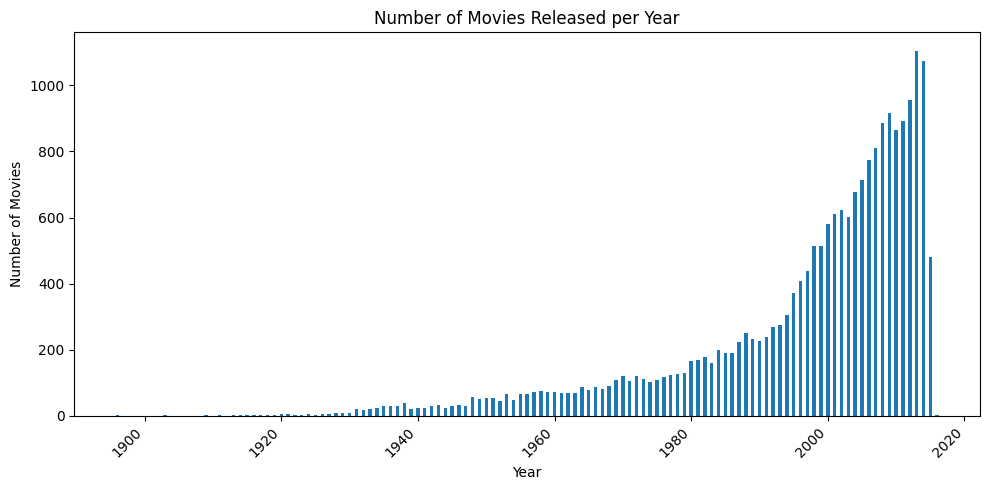

In [6]:
# Работа с запросами и вывод графиков

db = client['sample_mflix']
movies = db['movies']

# Подсчет общего количества фильмов по годам

# формирование запроса с агрегацией
pipeline = [
    {"$match": {"year": {"$type": 16}}},  # Filter for integer 'year' values
    {"$group": {"_id": "$year", "count": {"$sum": 1}}},
    {"$sort": {"_id": 1}}
]

# выполнение запроса
result = list(movies.aggregate(pipeline))

# извлекаем данные для графика
years = [item['_id'] for item in result]
counts = [item['count'] for item in result]

# График
plt.figure(figsize=(10, 5))
plt.bar(years, counts, width=0.5)
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.title("Number of Movies Released per Year")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

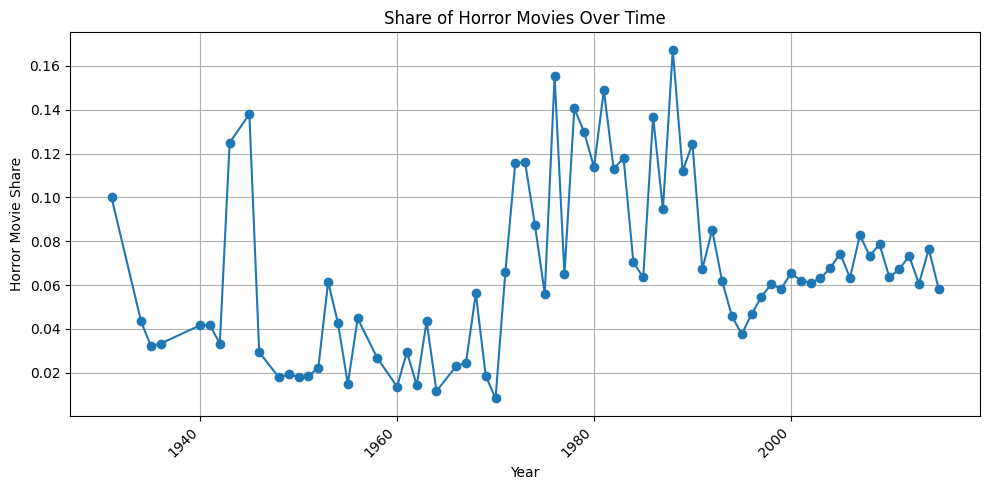

In [7]:
# график доли фильмов ужасов в общем объеме по годам
pipeline = [
    {"$match": {"year": {"$type": 16}, "genres": "Horror"}},  # Filter for integer 'year' and 'Horror' genre
    {"$group": {"_id": "$year", "horror_count": {"$sum": 1}}},  # Count horror movies per year
    {"$lookup": {
        "from": "movies",  # Join with the original 'movies' collection
        "let": {"year": "$_id"},
        "pipeline": [
            {"$match": {"$expr": {"$eq": ["$year", "$$year"]}, "year": {"$type": 16}}},  # Match by year and ensure integer 'year'
            {"$group": {"_id": None, "total_count": {"$sum": 1}}}  # Calculate total movies per year
        ],
        "as": "total_movies"
    }},
    {"$unwind": "$total_movies"},  # Unwind the 'total_movies' array
    {"$project": {
        "_id": "$_id",
        "horror_count": 1,
        "total_count": "$total_movies.total_count",
        "horror_share": {"$divide": ["$horror_count", "$total_movies.total_count"]}  # Calculate horror movie share
    }},
    {"$sort": {"_id": 1}}  # Sort by year
]

# Execute the pipeline
result = list(movies.aggregate(pipeline))

# Extract data for the graph
years = [item['_id'] for item in result]
horror_shares = [item['horror_share'] for item in result]

# Create the graph
plt.figure(figsize=(10, 5))
plt.plot(years, horror_shares, marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Horror Movie Share")
plt.title("Share of Horror Movies Over Time")
plt.grid(True)  # Add a grid for better readability
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.tight_layout()
plt.show()


In [8]:
# график распределения зависимости imdb рейтинга фильма от количества голосов
pipeline = [
    {
        "$match": {
            "imdb.rating": {"$exists": True, "$type": 1, "$gt": 0},
            "imdb.votes": {"$exists": True},  # Make sure the field exists
            "genres": "Horror"
        }
    },
    {
        "$project": {
            "rating": "$imdb.rating",
            "votes": {
                "$convert": {
                    "input": "$imdb.votes",
                    "to": "int",
                    "onError": 0  # Replace invalid values with 0
                }
            }
        }
    },
    {
        "$match": {
            "votes": {"$gt": 1000}  # Now apply the filter on the integer votes field
        }
    },
    {
        "$sort": {"votes": 1}
    }
]

result = list(movies.aggregate(pipeline))

ratings = [item['rating'] for item in result]
votes = [item['votes'] for item in result]


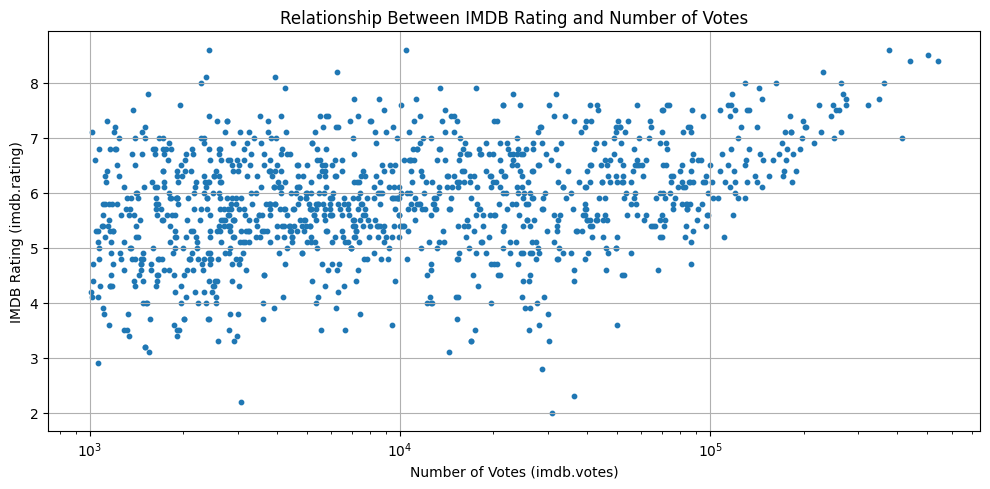

In [9]:
plt.figure(figsize=(10, 5))  # Adjust figure size if needed
plt.scatter(votes, ratings, marker='o', s=10)  # s controls marker size
plt.xlabel("Number of Votes (imdb.votes)")
plt.ylabel("IMDB Rating (imdb.rating)")
plt.title("Relationship Between IMDB Rating and Number of Votes")
plt.grid(True)
plt.xscale('log')  # Use logarithmic scale for x-axis
plt.tight_layout()
plt.show()

<ipython-input-11-9926144cb364>:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ratings_by_genre, labels=genres, vert=True, patch_artist=True) #vert=True for vertical boxplots


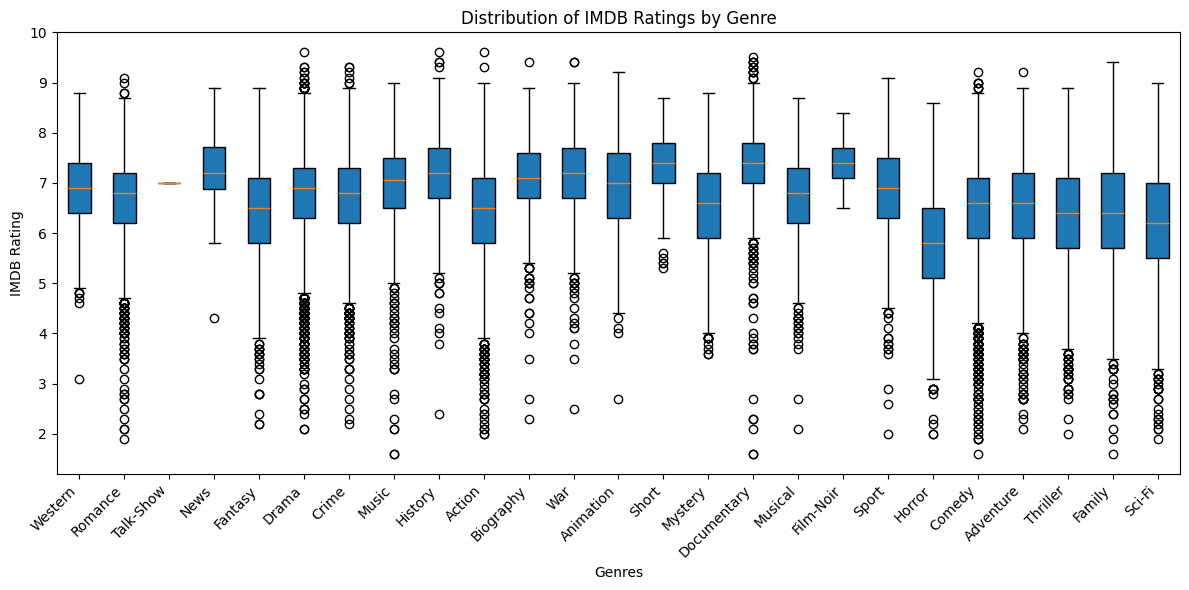

In [11]:
# график распределения рейтинга по жанрам
pipeline = [
    {
        "$match": {
            "imdb.rating": {"$exists": True, "$type": 1, "$gt": 0}, # Changed the filter to $gt: 0
            "genres": {"$exists": True, "$ne": []} # Ensure genres field exists and is not empty
        }
    },
    {
        "$unwind": "$genres" # Deconstruct the genres array
    },
    {
        "$group": {
            "_id": "$genres",
            "ratings": {"$push": "$imdb.rating"}
        }
    }
]

result = list(movies.aggregate(pipeline))

# Create box plots for each genre
plt.figure(figsize=(12, 6))
plt.title("Distribution of IMDB Ratings by Genre")

genres = [item['_id'] for item in result]
ratings_by_genre = [item['ratings'] for item in result]

plt.boxplot(ratings_by_genre, labels=genres, vert=True, patch_artist=True) #vert=True for vertical boxplots
plt.xlabel("Genres")
plt.ylabel("IMDB Rating")

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()